## One state variable
### Consumption-Based Model – Time-Varying Drift – Price Consumption Ratio
Here the setup is exactly the same as in example 1, but now I calculate the price consumption ratio instead of the price of zero coupon bond. The modified process in this case is:

$$
\mathrm{d}\tilde{x}_t=\big(-\log\phi(x_0-\bar{x}_t) +\rho_{cx}\sigma_c\sigma_x+\rho_{xD}\sigma_x\sigma_D\big)\mathrm{d}t+\sigma_{x}\mathrm{d}W_{ct}
$$

In order to get the price of the zero-coupon security a process for the integral of the short-term rate will also be needed:

$$
\mathrm{d}A = r(\tilde{x}_t)\mathrm{d}t
$$

##### Import the packages

In [1]:
import SDFFinance as sdf
import StochasticDiffEq as sde # this is needed in order to specify the algorithm

#### Define the parameters

In [2]:
cs = (
    phi = 0.92, # mean reversion
    x0 = 0.0, # long-run mean
    rho = 0.02, # time preference parameter
    gamma = 2, # risk aversion
    muc0 = 0.01, # mean of consumption drift
    sigmac = 0.01, # consumption diffusion
    sigmax = 0.005, # state variable diffusion
    rhocx = 0.3, # correlation between consumption and state variable
    sigmaD = 0.02, # dividend diffusion ###- added compared to example 1
    muD = 0.02, # dividend drift ###- added compared to example 1
    rhoxD = 0.5, # correlation between dividends and state variable ###- added compared to example 1
    rhocD = 0.4 # correlation between dividends and consumption ###- added compared to example 1
    # sigmaD = 0.01, # dividend diffusion ###- case of consumption perpetuity
    # muD = 0.01, # dividend drift ###- case of consumption perpetuity
    # rhoxD = 0.3, # correlation between dividends and state variable ###- case of consumption perpetuity
    # rhocD = 1.0 # correlation between dividends and consumption ###- case of consumption perpetuity
);

#### Drift and Diffusion of the processes
I also include the unmodified process which will correspond to "risk-neutral pricing". By comparing normal pricing with risk-neutral pricing it is possible to compute excess returns.

In [3]:
# diffusion of modified state
sigma(x,c) = c.sigmax; 
# drift of modified state
mu(x,c) = -log(c.phi)*(c.x0-x)-c.rhocx*c.gamma*c.sigmac*sigma(x,c)+c.rhoxD*sigma(x,c)*c.sigmaD 

mu (generic function with 1 method)

#### Short-term rate function

In [4]:
r(x,c) = c.rho+c.gamma*(c.muc0+0.1x)-c.gamma^2*c.sigmac^2/2;
r(x) = r(x,cs);
# muD(x) = cs.muD+x; # case of consumption perpetuity
muD(x) = cs.muD+x; # perpetuity with constant dividend drift
rmod(x,c) = r(x,c)-(muD(x)-c.gamma*c.rhocD*c.sigmac*c.sigmaD);
rmod(x) = rmod(x,cs);

#### Define setup consistent with SDE solution in Julia

In [5]:
function drift(du,u,p,t,c)
    du[1] = mu(u[1],c)
    du[2] = rmod(u[1],c)
end
drift(du,u,p,t) = drift(du,u,p,t,cs);
function diffusion(du,u,p,t,c)
    du[1] = sigma(u[1],c)
    du[2] = 0.0
end
diffusion(du,u,p,t) = diffusion(du,u,p,t,cs);

#### Define the Problem and SolutionSettings variables

In [6]:
prob = sdf.Problem(drift=drift,diffusion=diffusion,numNoiseVariables=1,outVariables=[2],
terminalFunction=(ik, x, y, z) -> exp(-x));
xRange = -0.05:0.002:0.05;
tRange = 0.0:5.0:300.0;
sett = sdf.SolutionSettings(xRanges=[xRange,], initialValues=[[x, 0.0] for x in xRange], 
algorithm=sde.LambaEM(), pathsPerInitialValue=5000, tRange=tRange);

#### Solve Problem and Define Yield

In [7]:
# ((consumptionStrip2,),) = sdf.solve(prob, sett);
# yld(t,x) = -log(consumptionStrip(t,x))/t;


In [7]:
sett2 = sdf.SolutionSettings(sett; continuousPayoffVars=[2])
((consumptionStrip,),(priceConsumptionRatio,)) = sdf.solve(prob, sett2);

#### Plot the yield

#### Integrate the Consumption Strips to Get the Price Consumption Ratio

In the theory I state that the price consumption ratio is computed from the integral over all consumption strip maturities. In practice it is not possible to integrate to infinity. So, I compute consumption strips up to a maturity of 300 years.

In [12]:
using QuadGK
integratedValues = [quadgk(t -> consumptionStrip(t, x), 0.0, tRange[end])[1] for x in xRange]
import DataInterpolations
#? this is a special interpolation that smooths the interpolation. In this case given the smoothness of the problem this slightly improves the interpolation. However this makes a big difference for the first and second derivatives of the interpolation (these can be necessary in order to compute the return). (interpolation info: https://github.com/SciML/DataInterpolations.jl)
# priceConsumptionRatio = DataInterpolations.BSplineApprox(integratedValues, 
#     collect(xRange), 3, 4, :Uniform, :Average, extrapolate=true)
priceConsumptionRatio2 = DataInterpolations.BSplineApprox(integratedValues, 
    collect(xRange), 3, 4, :Uniform, :Average, extrapolate=true)

BSplineApprox with 51 points, with degree 3, number of control points 4
┌────────┬─────────┐
│   time │       u │
├────────┼─────────┤
│  -0.05 │ 35.7631 │
│ -0.048 │ 36.3593 │
│ -0.046 │ 36.8499 │
│ -0.044 │ 37.4154 │
│ -0.042 │ 38.0222 │
│  -0.04 │ 38.6123 │
│ -0.038 │ 39.1723 │
│ -0.036 │ 39.5625 │
│ -0.034 │ 40.3051 │
│ -0.032 │ 41.1507 │
│  -0.03 │ 41.3763 │
│   ⋮    │    ⋮    │
│   0.03 │ 67.0049 │
│  0.032 │  67.203 │
│  0.034 │  68.974 │
│  0.036 │  69.974 │
│  0.038 │ 71.2365 │
│   0.04 │ 72.2652 │
│  0.042 │ 73.9797 │
│  0.044 │ 74.7781 │
│  0.046 │ 76.1109 │
│  0.048 │ 77.1426 │
│   0.05 │ 78.4702 │
└────────┴─────────┘
     29 rows omitted


#### Plot the Consumption Strip Term Structure

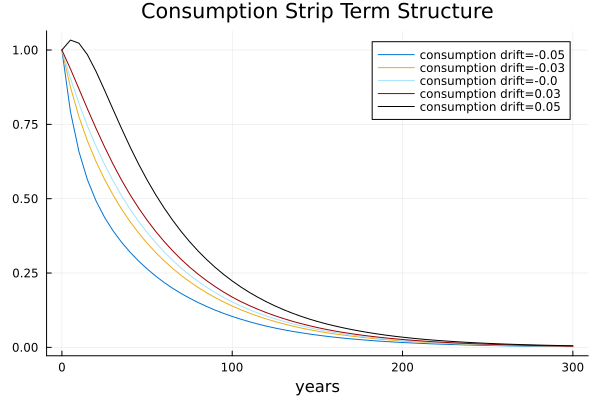

In [13]:
import Plots as plt
# # colors: "#0075d6", "#edad14", "#a3e3ff", "#9c0000", "#000000"
plt.plot(tRange, consumptionStrip.(tRange, -0.04),color="#0075d6", 
    title="Consumption Strip Term Structure", xlabel="years",label="consumption drift=-0.05")
plt.plot!(tRange, consumptionStrip.(tRange, -0.01),label="consumption drift=-0.03",color="#edad14")
plt.plot!(tRange, consumptionStrip.(tRange, 0.0),label="consumption drift=-0.0",color="#a3e3ff")
plt.plot!(tRange, consumptionStrip.(tRange, 0.01),label="consumption drift=0.03",color="#9c0000")
plt.plot!(tRange, consumptionStrip.(tRange, 0.04),label="consumption drift=0.05",color="#000000")


It can be seen that for all values of the state variable the price of the securities comes close to 0 for maturities as long as 300 years.

#### Plot the Price Consumption Ratio

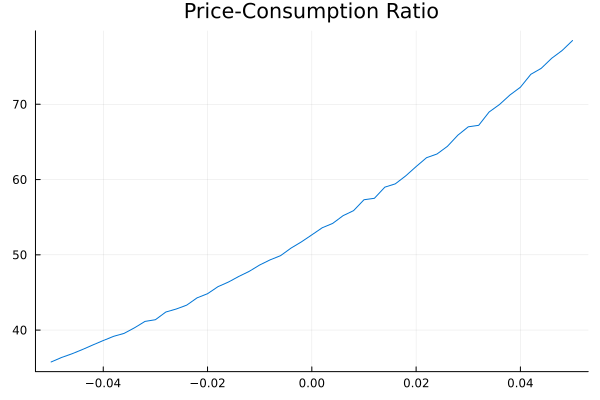

In [14]:
plt.plot(xRange, priceConsumptionRatio(xRange), legend=false,
    title="Price-Consumption Ratio",color="#0075d6")

#### Get the Return of the Consumption Perpetuity

The calculation requires the computation of the first and second derivatives of the price consumption ratio with respect to the state of the economy.

In [15]:
import DataInterpolations
DPC(x) = DataInterpolations.derivative(priceConsumptionRatio, x)
epsilon = 1e-5
D2PC(x) = x>0 ? (-DPC(x - epsilon) + DPC(x)) / epsilon : (DPC(x + epsilon) - DPC(x)) / epsilon


D2PC (generic function with 1 method)

In [8]:
typeof(priceConsumptionRatio.intp)

Interpolations.Extrapolation{Float64, 1, Interpolations.ScaledInterpolation{Float64, 1, Interpolations.BSplineInterpolation{Float64, 1, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, Interpolations.BSpline{Interpolations.Cubic{Interpolations.Line{Interpolations.OnGrid}}}, Tuple{Base.OneTo{Int64}}}, Interpolations.BSpline{Interpolations.Cubic{Interpolations.Line{Interpolations.OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, Interpolations.BSpline{Interpolations.Cubic{Interpolations.Line{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}

In [20]:
typeof(priceConsumptionRatio2)

DataInterpolations.BSplineApprox{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, true, Float64}

In [14]:
fieldnames(typeof(priceConsumptionRatio))

(:array, :intp, :singlePayoffSolution, :problem, :solutionSettings, :outVariable)

In [16]:
plt.plot(xRange, DPC.(xRange), legend=false,
    title="1st Derivative of Price-Consumption Ratio")

LoadError: type ContinuousPayoffSolution has no field t

In [18]:
plt.plot(xRange[2:end-1], D2PC.(xRange[2:end-1]), legend=false,
    title="2nd Derivative of Price-Consumption Ratio")

LoadError: UndefVarError: `DataInterpolations` not defined

In [ ]:
ret(x) = (DPC(x)*(mu(x, cs) + sigma(x, cs) * cs.sigmac * cs.rhocx) + 
    D2PC(x)* sigma(x, cs)^2/2.0 + 1.0)/priceConsumptionRatio(x) + muD(x)

ret (generic function with 1 method)

#### Plot the Return

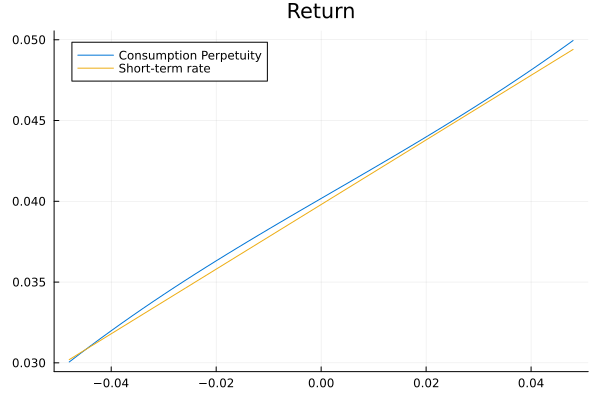

In [ ]:
plt.plot(xRange[2:end-1], ret.(xRange[2:end-1]), label="Consumption Perpetuity",
    title="Return", color="#0075d6")
plt.plot!(xRange[2:end-1], r.(xRange[2:end-1]),
    label="Short-term rate",color="#edad14")

As expected in the standard model with time-varying consumption drift the premium compared to the short-term rate is very low.